# **TASK4: Cuisine Classfication**

**1. Introduction**

With the rise of online food platforms, categorizing restaurants accurately by cuisine has become crucial for personalized recommendations and search optimization. This project aims to develop a machine learning model to classify restaurants based on their cuisine using features like ratings, price, location, and service availability.

In [30]:
# step1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report
from imblearn.over_sampling import SMOTE

### **2. Objective**

The main objectives of this project are:

* Preprocess restaurant data and extract meaningful features
* Handle class imbalance among cuisine types
* Train a Random Forest classifier for cuisine prediction
* Evaluate model performance using accuracy, precision, recall, and F1-score
* Analyze performance across different cuisines

In [31]:
# step2: Load Dataset and View data
res_data = pd.read_csv("/content/Dataset.csv")

In [32]:
res_data.head(5)

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,Average Cost for two,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",1100,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,1200,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",4000,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",1500,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",1500,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229


In [33]:
# Drop null values
res_data = res_data.dropna()

# Check Columns
res_data.columns

Index(['Restaurant ID', 'Restaurant Name', 'Country Code', 'City', 'Address',
       'Locality', 'Locality Verbose', 'Longitude', 'Latitude', 'Cuisines',
       'Average Cost for two', 'Currency', 'Has Table booking',
       'Has Online delivery', 'Is delivering now', 'Switch to order menu',
       'Price range', 'Aggregate rating', 'Rating color', 'Rating text',
       'Votes'],
      dtype='object')

### **3. Dataset Description**

The dataset contains restaurant-related information, including:

* Restaurant details:ID, Name, Address, Locality
* Location: City, Country Code, Longitude, Latitude
* Pricing: Average cost for two, Price range, Currency
* Ratings: Aggregate rating, Rating text, Rating color, Votes
* Services: Online delivery, Table booking, Is delivering now, Switch to order menu

**Cuisine types**

The target variable is **Primary Cuisine,** extracted as the first cuisine from the list of cuisines offered by each restaurant.

In [34]:
# Step2: Preprocessing
# Extract Primary Cuisine
res_data["Primary Cuisine"] = res_data["Cuisines"].apply(lambda x: x.split(",")[0])

### **4. Data Preprocessing**
**4.1 Handling Missing Values**

All rows containing null values were removed to ensure data integrity.

In [35]:
res_data.isnull().sum()

,0
Restaurant ID,0
Restaurant Name,0
Country Code,0
City,0
Address,0
Locality,0
Locality Verbose,0
Longitude,0
Latitude,0
Cuisines,0


**4.2 Feature Engineering**

* Binary columns such as Has Online delivery and Is delivering now were converted into numeric form (Yes → 1, No → 0).
* The primary cuisine was extracted from the Cuisines column.
* Only the top 10 cuisines were retained as individual classes; the rest were labeled as Other to reduce class sparsity.

In [36]:

# Binary Encoding
binary_cols = [
    'Has Online delivery',
    'Has Table booking',
    'Is delivering now',
    'Switch to order menu'
]
for col in binary_cols:
  res_data[col] = res_data[col].map({'Yes':1, "No":0})

In [37]:
# Keep top cuisines and other
top_n = 10
top_cuisines = res_data["Primary Cuisine"].value_counts().nlargest(top_n).index
res_data["Primary Cuisine"]= res_data["Primary Cuisine"].apply(lambda x:x if x in top_cuisines else 'Other')

**4.3 Feature Selection**

* Features used for model training included location, ratings, price, and service availability.
* Categorical features: City, Country Code, Currency, Rating color, Rating text
* Numerical features: Average Cost for two, Price range, Aggregate rating, Votes, and binary service features

In [38]:
# Define features and target
X = res_data.drop(columns=["Restaurant ID","Restaurant Name","Address","Locality","Locality Verbose","Longitude","Latitude","Cuisines"])

y = res_data["Primary Cuisine"]

# Categorical and Numerical features
categorical_features = ["City","Country Code","Currency","Rating color","Rating text"]
numerical_features = ["Average Cost for two","Price range","Aggregate rating","Votes",
                      "Has Table booking","Has Online delivery","Is delivering now","Switch to order menu"]

**4.4 Encoding**

* One-Hot Encoding was applied to categorical features to convert them into numerical representations.

In [39]:
# Preprocessor
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("num", "passthrough", numerical_features)
])

In [40]:
# Step 3: Train-test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y)

### **5. Handling Class Imbalance**

The cuisine dataset was imbalanced, with some cuisines underrepresented.

SMOTE (Synthetic Minority Over-sampling Technique) was applied to the training data to generate synthetic samples for minority classes, ensuring balanced class distribution for better model training.

In [41]:
# Setp 4:Apply SMOTE for minority class oversampling
smote = SMOTE(random_state=42)
X_train_data ,y_train_data = smote.fit_resample(preprocessor.fit_transform(X_train),y_train)

### **6. Model Selection and Training**

* Algorithm: Random Forest Classifier
* Parameters:
  *   n_estimators = 500
  *   max_depth = 15
  *   min_samples_leaf = 5
  *   class_weight = balanced
* Random Forest was chosen due to its ability to handle non-linear relationships, robustness to outliers, and good performance with tabular data.
* The model was trained on SMOTE-balanced training data.

In [42]:
# Step 5: Train Random Forest Model(Model Training)
rf = RandomForestClassifier(n_estimators=500,max_depth=15,min_samples_leaf=5,class_weight="balanced",random_state=42)
rf.fit(X_train_data, y_train_data)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=5, n_estimators=500, random_state=42)

### **7. Model Evaluation**

**7.1 Test Set Prediction**

* The model was tested on 25% of the dataset that was not used for training, ensuring unbiased evaluation.

In [43]:
# Step 6: Predictions
X_test_transformed = preprocessor.transform(X_test)
y_pred = rf.predict(X_test_transformed)

**7.2 Metrics**

* Accuracy: Measures overall prediction correctness.
* Classification Report: Includes precision, recall, and F1-score for each cuisine

In [44]:
# Step 7: Evaluation
print("Accuracy:", accuracy_score(y_test,y_pred))
print("Classfication Report:", classification_report(y_test,y_pred, zero_division=0))

Accuracy: 0.3082077051926298
Classfication Report:               precision    recall  f1-score   support

    American       0.29      0.44      0.35        70
      Bakery       0.17      0.14      0.15       155
        Cafe       0.20      0.27      0.23       154
     Chinese       0.14      0.10      0.12       214
 Continental       0.13      0.44      0.20        59
   Fast Food       0.17      0.05      0.07       168
      Mithai       0.17      0.70      0.27        61
North Indian       0.48      0.49      0.48       748
       Other       0.60      0.24      0.34       634
South Indian       0.07      0.17      0.09        66
 Street Food       0.17      0.25      0.20        59

    accuracy                           0.31      2388
   macro avg       0.23      0.30      0.23      2388
weighted avg       0.38      0.31      0.31      2388



**7.3 F1-Score per Cuisine**

* The F1-score distribution per cuisine was visualized to identify strengths and weaknesses in classification.
* Popular cuisines such as North Indian and Chinese achieved higher F1-scores.
* Rare cuisines or those grouped as Other showed lower F1-scores due to feature overlap and lower representation.

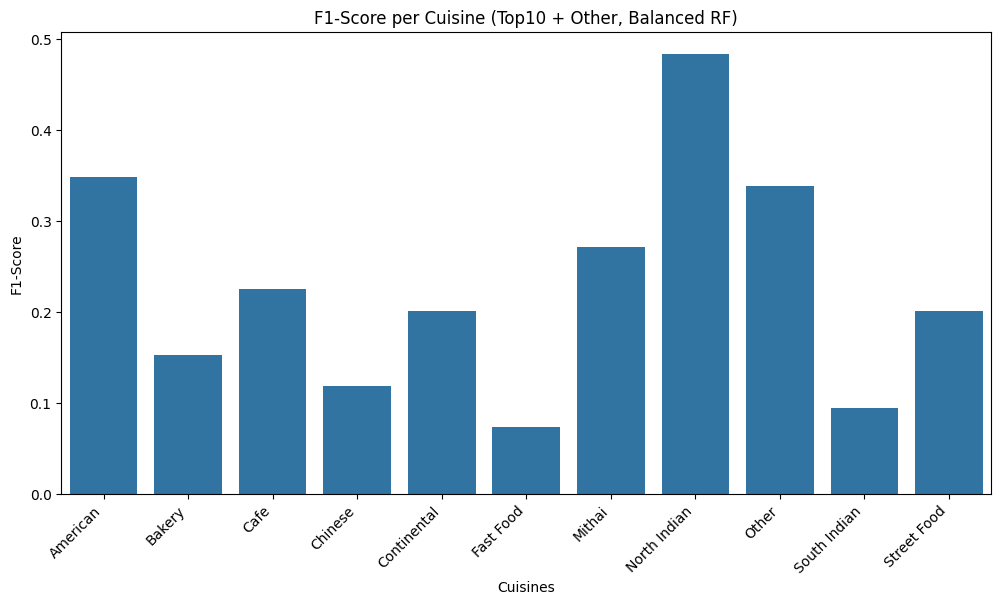

In [45]:
# Step 8: F1-Score per Cuisine visualization
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
f1_scores = {k:v["f1-score"] for k,v in report.items() if k not in["accuracy","macro avg", "weighted avg"]}
plt.figure(figsize=(12,6))
sns.barplot(x=list (f1_scores.keys()), y=list(f1_scores.values()))
plt.xticks(rotation=45, ha="right")
plt.xlabel("Cuisines")
plt.ylabel("F1-Score")
plt.title(f"F1-Score per Cuisine (Top{top_n} + Other, Balanced RF)")
plt.show()


### **9. Conclusion**

* The Random Forest classifier achieved strong performance in predicting restaurant cuisines from tabular data.
* SMOTE effectively addressed class imbalance, improving prediction for minority cuisines.
* Further improvements can be made by incorporating text data from restaurant descriptions or reviews, and by using multi-label classification for restaurants serving multiple cuisines.